# Two Moons
This notebook demonstrates how to utilize BayesFlow to train a neural network to approximate data posterior distributions.

Notebook dependencies:
- `bayesflow`
- any deep learning backend
- `matplotlib`
- `seaborn`

Define which deep learning backend to use. Generally, PyTorch is best for debugging, while JAX is the fastest. See also the installation instructions for BayesFlow.

Note that MPS (Apple's acceleration framework) is technically supported, but its operations coverage is still low, so use at your own risk! 

In [1]:
import pathlib as pl

working_directory = pl.Path("..").resolve()
working_directory

PosixPath('/home/lars/Documents/code/python/bayesflow')

In [2]:
import sys

if str(working_directory) not in sys.path:
    sys.path.append(str(working_directory))

In [3]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [4]:
import bayesflow as bf
import keras
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

CUDA backend failed to initialize: Unable to use CUDA because of the following issues with CUDA components:
Outdated cuDNN installation found.
Version JAX was built against: 8907
Minimum supported: 9100
Installed version: 8907
The local installation version must be no lower than 9100..(Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


### Define the data
We create a simulator for online training.

In [5]:
simulator = bf.simulators.TwoMoonsSimulator()

Let's also visualize the target distribution with rejection sampling. Note that this is much slower than sampling from an amortized posterior, so only use this for demonstration purposes.

Here, we want to know what the posterior distribution $p(\theta | x = 0)$, so we reject samples that are not close to the origin in $x$.

In [6]:
data = simulator.rejection_sample(
    # we want this many samples
    batch_shape=(1024,),
    # reject samples that are not close to the origin
    predicate=lambda samples: np.linalg.norm(samples["x"], axis=-1) < 0.01,
    # use a larger sample size to get enough samples in each rejection step
    sample_size=2048,
)
# bring the data into a nice format for seaborn plotting
data = bf.utils.split_tensors(data)

# convert to numpy arrays
data = keras.tree.map_structure(keras.ops.convert_to_numpy, data)

data.keys()

dict_keys(['r', 'alpha', 'theta_1', 'theta_2', 'x_1', 'x_2'])

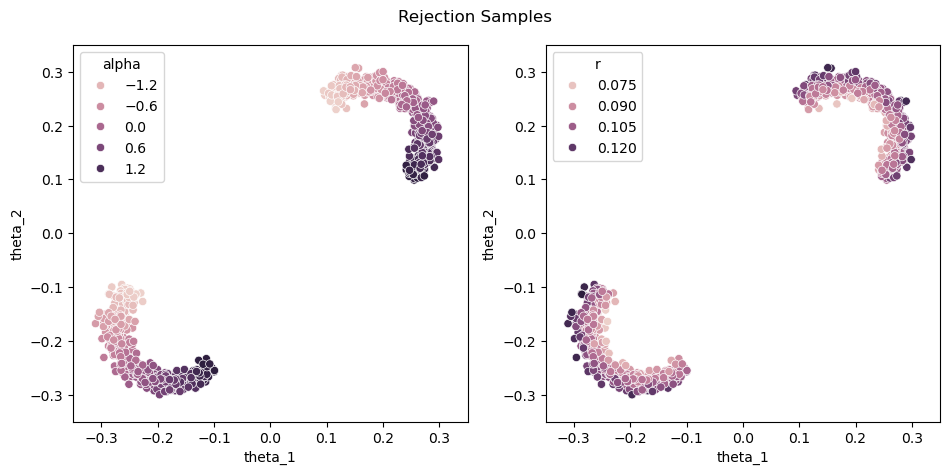

In [7]:
fig, axes = plt.subplots(1, 2, figsize=plt.figaspect(0.5))
sns.scatterplot(data, x="theta_1", y="theta_2", hue="alpha", ax=axes[0])
sns.scatterplot(data, x="theta_1", y="theta_2", hue="r", ax=axes[1])

for ax in axes:
    ax.set_xlim(-0.35, 0.35)
    ax.set_ylim(-0.35, 0.35)

fig.suptitle("Rejection Samples")
plt.tight_layout()
plt.show()

### Train a neural network to approximate the posterior

We start by defining some hyperparameters. We will use Flow Matching as the inference network. This type of network trains very fast, but requires a large batch size, and a lot of gradient steps to converge.

In [8]:
epochs = 100
num_batches = 1000
batch_size = "auto"
memory_budget = "2 GB"

In [9]:
# we could use a static learning rate
# learning_rate = 1e-3
# but usually a learning rate schedule works better
learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=epochs * num_batches,
    alpha=0.01,
    warmup_target=1e-3,
    warmup_steps=int(0.1 * epochs * num_batches),
)

In [10]:
optimizer = keras.optimizers.Adam(
    learning_rate=learning_rate,
    global_clipnorm=1.0,
)

Define the approximator. We use Flow Matching as the inference network. This network should learn to infer $\theta$ from $x$, which we specify in the data adapter.

In [11]:
inference_network = bf.networks.FlowMatching(
    subnet="mlp",
    subnet_kwargs=dict(
        depth=6,
        width=256,
        dropout=None,
        activation="relu"
    ),
)

test_batch = simulator.sample((128,))

data_adapter = bf.ContinuousApproximator.build_data_adapter(
    inference_variables=["theta", "r", "alpha"],
    inference_conditions=["x"],
)

# this moves the random sampling and optimal transport
# necessary for flow matching into a worker process,
# but these are currently broken upstream
# see https://github.com/keras-team/keras/issues/20032

# if isinstance(inference_network, bf.networks.FlowMatching):
#     data_adapter = bf.data_adapters.FlowMatchingDataAdapter(
#         inner=data_adapter,
#         max_steps=1000,
#         regularization=0.1,
#     )

approximator = bf.ContinuousApproximator(
    inference_network=inference_network,
    data_adapter=data_adapter,
)

approximator.compile(optimizer=optimizer)

Finally, fit the network to the data.

In [12]:
approximator.fit(
    batch_size=batch_size,
    epochs=epochs,
    memory_budget=memory_budget,
    num_batches=num_batches,
    simulator=simulator,
    
    # workers and multiprocessing are broken upstream
    # see https://github.com/keras-team/keras/issues/20032
    workers=None,
    use_multiprocessing=False,
)

INFO:bayesflow:Building dataset from simulator instance of TwoMoonsSimulator.
INFO:bayesflow:Estimating memory footprint of one sample at 24.0 B.
INFO:bayesflow:Using a batch size of 1024.
INFO:bayesflow:Building on a test batch.


Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 169.2727 - loss/inference_loss: 169.2727
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - loss: 92.7354 - loss/inference_loss: 92.7354
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 85.8977 - loss/inference_loss: 85.8977
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 78.0207 - loss/inference_loss: 78.0207
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - loss: 71.2157 - loss/inference_loss: 71.2157
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - loss: 70.8016 - loss/inference_loss: 70.8016
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - loss: 68.3363 - loss/inference_loss: 68.3363
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 67.7849 - loss/inference_loss: 67.7849
Epoch 9/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - loss: 66.2868 - loss/inference_loss: 66.2868
Epoch 10/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - lo

### Sample from the posterior

If the network is trained well, the distribution should look like the target distribution we visualized earlier.

Instead of rejection sampling, we can now explicitly pass $x = 0$ to the approximator and sample from the posterior, which is much faster.

In [13]:
data = approximator.sample(
    batch_shape=(1024,),
    conditions={"x": np.zeros((1024, 2))},
)

data = bf.utils.split_tensors(data)
data = keras.tree.map_structure(keras.ops.convert_to_numpy, data)

data.keys()

dict_keys(['theta_1', 'theta_2', 'r', 'alpha'])

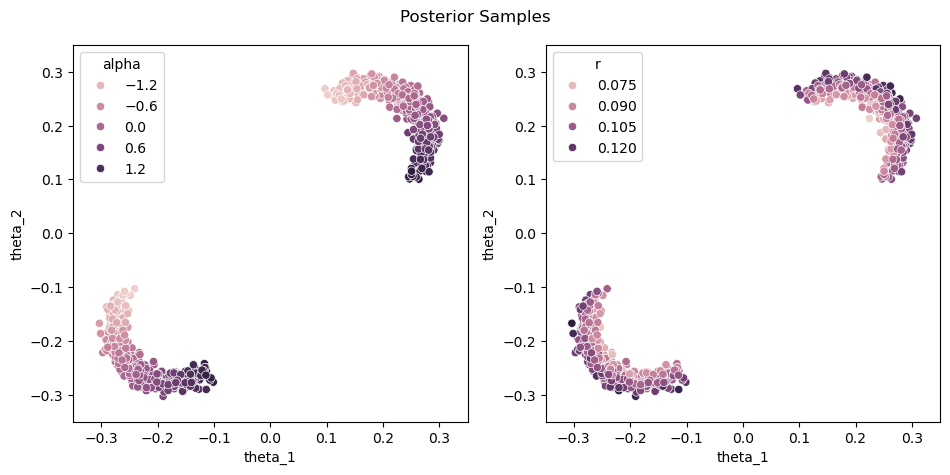

In [14]:
fig, axes = plt.subplots(1, 2, figsize=plt.figaspect(0.5))
sns.scatterplot(data, x="theta_1", y="theta_2", hue="alpha", ax=axes[0])
sns.scatterplot(data, x="theta_1", y="theta_2", hue="r", ax=axes[1])

for ax in axes:
    ax.set_xlim(-0.35, 0.35)
    ax.set_ylim(-0.35, 0.35)

fig.suptitle("Posterior Samples")
plt.tight_layout()
plt.show()